In [1]:
import torch
from torch import nn
import pathlib
from pathlib import Path
import zipfile
import shutil
import os
import random
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
from ipynb.fs.defs.FashionMNIST import *
from torchmetrics import Accuracy, ConfusionMatrix
import torchinfo
from torchinfo import summary


## Get data

In [2]:
data_path = Path('Foodvision_data')
data_path.mkdir(exist_ok=True,
                parents=True)

shutil.copy('/Users/navalmor/Desktop/pytorch/Food_images_classification/data/pizza_steak_sushi.zip',
            '/Users/navalmor/Desktop/PyTorch_Learning/computer vision/Foodvision_data')

with zipfile.ZipFile('/Users/navalmor/Desktop/PyTorch_Learning/computer vision/Foodvision_data/pizza_steak_sushi.zip', 'r') as z:
    z.extractall('/Users/navalmor/Desktop/PyTorch_Learning/computer vision/Foodvision_data/pizza_steak_sushi')

In [3]:
def get_data(dir):
    for dir_path, dir_name, file_name in os.walk(dir):
        print(f"There are {len(dir_name)} directories {dir_name} and {len(file_name)} images in {dir_path}")
        #print(f"{dir_path} | {dir_name} | {file_name}")

get_data(data_path)

There are 1 directories ['pizza_steak_sushi'] and 2 images in Foodvision_data
There are 2 directories ['test', 'train'] and 0 images in Foodvision_data/pizza_steak_sushi
There are 3 directories ['steak', 'sushi', 'pizza'] and 0 images in Foodvision_data/pizza_steak_sushi/test
There are 0 directories [] and 19 images in Foodvision_data/pizza_steak_sushi/test/steak
There are 0 directories [] and 31 images in Foodvision_data/pizza_steak_sushi/test/sushi
There are 0 directories [] and 25 images in Foodvision_data/pizza_steak_sushi/test/pizza
There are 3 directories ['steak', 'sushi', 'pizza'] and 0 images in Foodvision_data/pizza_steak_sushi/train
There are 0 directories [] and 75 images in Foodvision_data/pizza_steak_sushi/train/steak
There are 0 directories [] and 72 images in Foodvision_data/pizza_steak_sushi/train/sushi
There are 0 directories [] and 78 images in Foodvision_data/pizza_steak_sushi/train/pizza


## Plot image

Image path: Foodvision_data/pizza_steak_sushi/train/pizza/3589437.jpg
Image label: pizza
Image width: 512
Image height:288


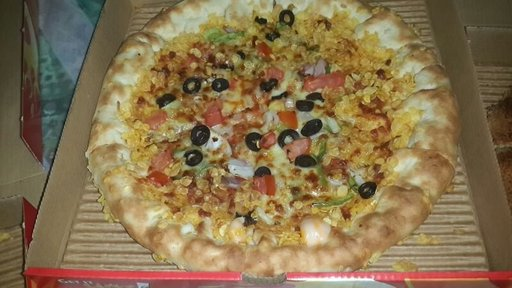

In [4]:
image_path = data_path/'pizza_steak_sushi'
image_path_list = list(image_path.glob('*/*/*.jpg'))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)
print(f"Image path: {random_image_path}")
print(f"Image label: {image_class}")
print(f"Image width: {img.width}\nImage height:{img.height}")
img

## Transform data

In [5]:
transformed_data = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=11)
])

## Create custom ImageLoader

In [6]:
def find_classes(dir):
    classes = sorted(i.name for i in os.scandir(dir))
    im_path = list(Path(dir).glob('*/*.jpg'))
    im_path_class = [i.parent.name for i in im_path]
    if classes:
        class_to_idx = {class_name : j for j, class_name in enumerate(classes)}
        im_path_class_idx = []
        for idx in im_path_class:
            im_path_class_idx.append(class_to_idx[idx])
    return classes, class_to_idx, im_path_class_idx


class ImageFolderCustom(Dataset):
    def __init__(self,
                 dir : str,
                 data_transform = None):
         self.image_path = list(pathlib.Path(dir).glob('*/*.jpg'))
         self.data_transform = data_transform
         self.classes, self.class_to_idx, self.targets = find_classes(dir)
    def load_image(self, index : int):
        img_path = self.image_path[index]
        return Image.open(img_path)
    
    def __len__(self):
        return len(self.image_path)
    
    def __getitem__(self, index : int):
        img = self.load_image(index)
        cls = self.image_path[index].parent.name
        cls_idx = self.class_to_idx[cls]
        if self.data_transform:
            return self.data_transform(img), cls_idx
        return img, cls_idx
    
    def target(self):
        return self.targets

In [7]:
train_data = ImageFolderCustom(dir=Path('/Users/navalmor/Desktop/PyTorch_Learning/computer vision/Foodvision_data/pizza_steak_sushi/train'),
                               data_transform=transformed_data)

test_data = ImageFolderCustom(dir=Path('/Users/navalmor/Desktop/PyTorch_Learning/computer vision/Foodvision_data/pizza_steak_sushi/test'),
                              data_transform=transformed_data)

## Create dataloader

In [8]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=5,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=5,
                             shuffle=False)

## Build model

In [9]:
class FoodVisionModel(nn.Module):
    def __init__(self,
                 in_features :int,
                 hidden_units :int,
                 out_features :int):
        super().__init__()

        self.conv_stack_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_features,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.Tanh(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_stack_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.Tanh(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_stack_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.linear_classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*3136,
                      out_features=out_features)
        )

    def forward(self, X :torch.Tensor):
        print(X.shape)
        X = self.conv_stack_1(X)
        #print(X.shape)
        X = self.conv_stack_2(X)
        #print(X.shape)
        #X = self.conv_stack_3(X)
        #print(X.shape)
        X = self.linear_classifier(X)
        #print(X.shape)
        return(X)


In [10]:
model = FoodVisionModel(3,20,len(train_data.classes))

In [11]:
model(train_data[0][0].unsqueeze(0))

torch.Size([1, 3, 224, 224])


/opt/homebrew/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor([[ 0.0279, -0.0285, -0.0062]], grad_fn=<AddmmBackward0>)

In [12]:
62720/20

3136.0

## Define train/eval function

In [13]:
torch.manual_seed(42)

def train_model(model :torch.nn.Module,
                train_dataloader :DataLoader,
                loss_fn :nn.functional,
                acc_fn :nn.functional,
                optimizer :torch.optim):
    model.train()
    train_loss = 0
    train_acc = 0
    for X,y in train_dataloader:
        train_logits = model(X)
        train_loss += loss_fn(train_logits, y)
        train_pred = torch.softmax(train_logits, dim=1).argmax(dim=1)
        train_acc += acc_fn(train_pred, y)
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    return train_loss, train_acc*100


def eval_model(model :nn.Module,
               test_dataloader :DataLoader,
               loss_fn :nn.functional,
               acc_fn :nn.functional):
    model.eval()
    with torch.inference_mode():
        test_loss = 0
        test_acc = 0
        for X,y in test_dataloader:
            test_logits = model(X)
            test_loss += loss_fn(test_logits, y)
            test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
            test_acc += acc_fn(test_pred, y)
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        return test_loss, test_acc*100

## Run train/test loop

In [14]:
loss_fn = nn.CrossEntropyLoss()
acc_fn = Accuracy(task='multiclass',
                  num_classes=3)
optimizer = torch.optim.Adam(params=model.parameters(),
                            lr=0.001)
epochs = 50
epoch_values = []
train_loss_values = []
test_loss_values = []
for epoch in range(epochs):
    train_loss, train_acc = train_model(model=model,
                                        train_dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        acc_fn=acc_fn,
                                        optimizer=optimizer)
    test_loss, test_acc = eval_model(model=model,
                                     test_dataloader=test_dataloader,
                                     loss_fn=loss_fn,
                                     acc_fn=acc_fn)
    if epoch%1==0:
        print(f"Epoch : {epoch} | Train_loss : {train_loss :.3f} | Train_acc : {train_acc :.2f}% | Test_loss : {test_loss :.3f} | test_acc : {test_acc :.2f}%")
        epoch_values.append(epoch)
        train_loss_values.append(train_loss)
        test_loss_values.append(test_loss)

torch.Size([5, 3, 224, 224])
torch.Size([5, 3, 224, 224])


TypeError: Threshold should be less than bound of img.

## Plot train/test loss

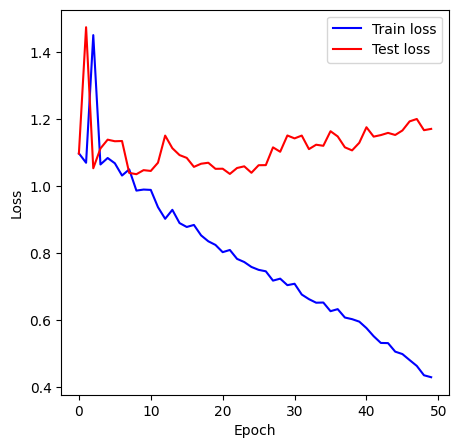

In [232]:
with torch.inference_mode():
    plt.figure(figsize=(5,5))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(epoch_values, train_loss_values, c='b', label='Train loss')
    plt.plot(epoch_values, test_loss_values, c='r', label='Test loss')
    plt.legend()

## Plot confusion metrics

In [237]:
def make_pred(model :nn.Module,
              data :torch.Tensor):
    pred = []
    for X, y in data:
        logit = model(X.unsqueeze(dim=0))
        prediction = logit.argmax()
        pred.append(prediction.item())
    return pred

test_pred = make_pred(model, test_data)

/opt/homebrew/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [238]:
confusion_matrics = ConfusionMatrix(task='multiclass',
                                    num_classes=len(train_data.classes))
confusion_matrics_tensor = confusion_matrics(preds=torch.Tensor(test_pred),
                                             target=torch.Tensor(test_data.targets))
confusion_matrics_tensor

tensor([[14,  5,  6],
        [ 3, 10,  6],
        [11,  4, 16]])

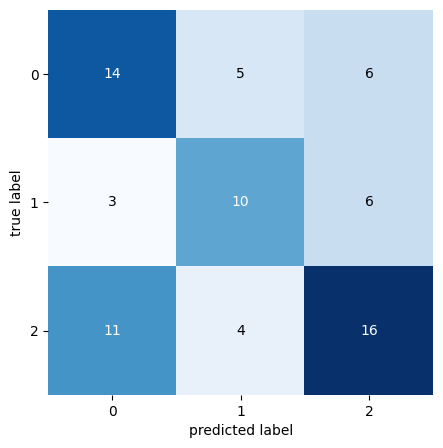

In [241]:
figure, axis = plot_confusion_matrix(
    confusion_matrics_tensor.numpy(),
    test_data.classes,
    figsize=(5,5)
)

In [242]:
summary(model, input_data=train_data[0][0].unsqueeze(0))

Layer (type:depth-idx)                   Output Shape              Param #
FoodVisionModel                          [1, 3]                    7,240
├─Sequential: 1-1                        [1, 20, 64, 64]           --
│    └─Conv2d: 2-1                       [1, 20, 128, 128]         560
│    └─Tanh: 2-2                         [1, 20, 128, 128]         --
│    └─Conv2d: 2-3                       [1, 20, 128, 128]         3,620
│    └─Tanh: 2-4                         [1, 20, 128, 128]         --
│    └─MaxPool2d: 2-5                    [1, 20, 64, 64]           --
├─Sequential: 1-2                        [1, 20, 32, 32]           --
│    └─Conv2d: 2-6                       [1, 20, 64, 64]           3,620
│    └─Tanh: 2-7                         [1, 20, 64, 64]           --
│    └─Conv2d: 2-8                       [1, 20, 64, 64]           3,620
│    └─Tanh: 2-9                         [1, 20, 64, 64]           --
│    └─MaxPool2d: 2-10                   [1, 20, 32, 32]           --
├─

In [243]:
torch.save(model, '/Users/navalmor/Desktop/PyTorch_Learning/computer vision/models/FoodvisionModel.pt')

In [244]:
test_data.classes

['pizza', 'steak', 'sushi']